<a href="" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicción de edades (4 pts.)

En este ejercicio debes entrenar modelos de regresión para predecir edades en el conjunto de datos UTKFace. La solución debe cumplir con los siguientes puntos.

* Implementar la tubería de datos usando el conjunto de rostros alineados y recortados
.
* Agregar acrecentamiento de datos usando un espejeo horizontal.
* Dividir aleatoriamente en subconjuntos entrenamiento 80 % y prueba 20 %.
* Entrenar modelo con arquitectura ResNet vista en la libreta https://github.com/gibranfp/CursoAprendizajeProfundo/blob/2023-1/notebooks/2c_cnn_resnet.ipynb, pero cambiando los bloques ResNet por bloques ConNeXt.
* Usando transferencia de conocimiento, entrenar un modelo reentrenando solo la última capa.
* Usando transferencia de conocimiento, entrenar un modelo reentrenando toda la red.
* Discutir el comportamiento durante el entrenamiento y resultados finales en ambos conjuntos.

## 1 Preparación

In [1]:
# biblioteca para inspeccionar arquitecturas
# https://github.com/tyleryep/torchinfo
!pip install torch-summary

In [2]:
!pip install -q torchinfo

### 1.1. Bibliotecas

In [3]:
# funciones aleatorias
import random
# tomar n elementos de una secuencia
from itertools import islice as take
# sistema de archivos
import os
import datetime
import time

# gráficas
import matplotlib.pyplot as plt
# arreglos multidimensionales
import numpy as np
# csv
import pandas as pd
# redes neuronales
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets.utils as tvutils
import torchvision.models as tvm
import torchvision.transforms as T
# imágenes
from skimage import io
from skimage.transform import resize
# redes neuronales
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
# inspección de arquitectura
# https://github.com/TylerYep/torch-summary
from torchsummary import summary as summary_torchsummary
from torchinfo import summary as summary_torchinfo
# barras de progreso
from tqdm import tqdm
# barra de progreso
from tqdm.auto import trange
# trazas de Tensorboard
from torch.utils.tensorboard import SummaryWriter
# imágenes
from PIL import Image
# Dividir dataset
from torch.utils.data import random_split

### 1.2. Auxiliares


In [4]:
# Directorio de datos
URL = 'https://cloud.xibalba.com.mx/s/QpJdJ5aLEDG9Ryb/download'
base_dir = '../data/UTKFace'
filename = 'UTKFace.tar.gz'
data_dir = '../data/UTKFace/UTKFace'
filepath = os.path.join(base_dir, filename)

# Tamaño del lote
BATCH_SIZE = 32
# Filas y columnas de la rejilla de imágenes
ROWS, COLS = 4, 8
# Tamaño de la imagen
IMG_SIZE = 224

# media y varianza de de ImageNet
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

def crop_center(img, cropx, cropy):
    y, x = img.shape[:2]
    startx = x // 2 - cropx // 2
    starty = y // 2 - cropy // 2    
    return img[starty:starty+cropy, startx:startx+cropx]


def display_grid(xs, titles, rows, cols, figsize=(12, 6)):
    """Displays examples in a grid."""
    fig, ax = plt.subplots(rows, cols, figsize=figsize)
    i = 0
    for r in range(rows):
        for c in range(cols):
            ax[r, c].imshow(xs[i], cmap='gray')
            ax[r, c].set_title(titles[i])
            ax[r, c].set_xticklabels([])
            ax[r, c].set_yticklabels([])
            i += 1
    fig.tight_layout()
    plt.show()


def display_batch(x, titles, rows, cols, figsize=(12, 6)):
    """Displays a batch of processed examples in a grid."""
    # denormalizamos [0, 1] => [0, 255]
    x *= 255
    # rotamos canales (C x H x W) => (H x W x C)
    x = x.permute(0, 2, 3, 1)
    # convertimos a entero
    x = (x.numpy()).astype(np.uint8)
    # desplegamos
    display_grid(x, titles, rows, cols, figsize)
    
def display_batch_IMAGENET(x, titles, rows, cols, figsize=(12, 6)):
    """Despliega un lote en una cuadrícula."""
    # denormalizamos
    for c, (mean, std) in enumerate(zip(IMAGENET_MEAN, IMAGENET_STD)):
        x[:, c] = x[:, c] * std + mean 
    x *= 255
    # rotamos canales
    x = x.permute(0, 2, 3, 1)
    # convertimos a entero
    x = (x.numpy()).astype(np.uint8)
    # desplegamos lote
    display_grid(x, titles, rows, cols, figsize)

def timestamp(fmt='%y%m%dT%H%M%S'):
    """Regresa la marca de tiempo."""
    return datetime.datetime.fromtimestamp(time.time()).strftime(fmt)

def set_seed(seed=0):
    """Initializes pseudo-random number generators."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)


def numpy_to_torch(x):
    x = transforms.functional.to_tensor(x)
    x = x.type(torch.float32)
    return x


# reproducibilidad
set_seed()

## 2 Datos

<img src="https://raw.githubusercontent.com/gibranfp/CursoAprendizajeProfundo/e9fbbe09478011ee08fe45ce2afb63db3fa2c8df/figs/comida_datos.svg" width="1050"/>
&nbsp;
Tuberia de datos para UTKFace.

### 2.2 Descarga de UTKFace

In [5]:
! mkdir -p {base_dir}
! wget -nc {URL} -O {filepath}
! tar -zxf {filepath} -C {base_dir}

#360 x 240
#649 x 649
#200 x 200

--2022-11-14 02:26:09--  https://cloud.xibalba.com.mx/s/QpJdJ5aLEDG9Ryb/download
Resolving cloud.xibalba.com.mx (cloud.xibalba.com.mx)... 187.188.130.162
Connecting to cloud.xibalba.com.mx (cloud.xibalba.com.mx)|187.188.130.162|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106634631 (102M) [application/x-gzip]
Saving to: ‘../data/UTKFace/UTKFace.tar.gz’

../data/UTKFace/UTK 100%[===================>] 101.69M  2.68MB/s    in 28s     

2022-11-14 02:26:39 (3.59 MB/s) - ‘../data/UTKFace/UTKFace.tar.gz’ saved [106634631/106634631]



### 2.3 Conjunto de datos

In [6]:
! ls {data_dir}/ | head -5

100_0_0_20170112213500903.jpg.chip.jpg
100_0_0_20170112215240346.jpg.chip.jpg
100_1_0_20170110183726390.jpg.chip.jpg
100_1_0_20170112213001988.jpg.chip.jpg
100_1_0_20170112213303693.jpg.chip.jpg
ls: write error: Broken pipe


In [7]:
class UTKFaceDS:

    #root es el directorio de datos principal
    #en este caso contiene las imagenes directamente
    def __init__(self, root, tsfm):
        
        # Guardamos la tranformación para las imágenes
        self.tsfm = tsfm
       
        # lista con las rutas a las imágenes
        self.paths = []
        # lista con las etiquetas de las imágenes
        self.labels = []
        
        # Por cada imagen del directorio base
        for image_filename in os.listdir(root):
            # Extrae la ruta completa
            image_path = os.path.join(root, image_filename)
            variables = image_filename.split('_')
            # Y su edad asociada
            edad = int(variables[0])
            # Guarda las rutas y sus etiquetas
            self.paths.append(image_path)
            self.labels.append(edad)

    def __getitem__(self, i):
        # Se obtiene la ruta de la imagen
        path = self.paths[i]
        # Se carga la imagen
        x = Image.open(path)
        # Se aplica la transformación
        x = self.tsfm(x)
        # Se lee la etiqueta
        y = np.array(self.labels[i], np.float32).reshape(1)
        # Se regresa el ejemplo
        return x, y

    def __len__(self):
        # Número de ejemplos en el conjunto
        return len(self.paths)

### 2.4 Exploración

x shape=torch.Size([32, 224, 224, 3]) dtype=torch.uint8
y shape=torch.Size([32, 1]) dtype=torch.float32


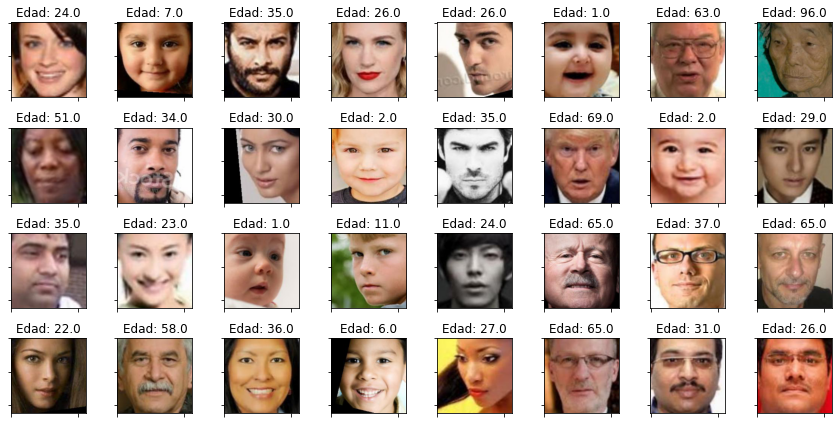

In [8]:
tsfm = transforms.Compose([
    # redimensionamos a 224x224
    transforms.Resize(IMG_SIZE),
    # recortamos al centro a 224x224
    transforms.CenterCrop(IMG_SIZE),
    # espejeo horizontal con probabilidad de 0.5
    transforms.RandomHorizontalFlip(p=0.5),
    # convertimos a ndarray
    np.array
])

ds = UTKFaceDS(data_dir, tsfm)

dl = DataLoader(
    # conjunto
    ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True
)

# desplegamos un lote de imágenes
x, y = next(iter(dl))
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')
titles = [f'Edad: {l.item()}' for l in y]
display_grid(x, titles, ROWS, COLS)

### 2.3 Cargador de datos

#### División de datos
Se crean un dataset de la clase UTKFaceDS, sin ninguna transformación, y se divide en dos dataset, uno para los datos de entrenamiento 80% y otro para prueba 20%.

In [9]:
from copy import copy

dsAll = UTKFaceDS(data_dir, None)

train_size = int(0.8 * len(dsAll))
test_size = len(dsAll) - train_size
trn_ds, tst_ds = random_split(dsAll, [train_size, test_size], generator=torch.Generator().manual_seed(0))

# trn_ds y tst_ds son una clase de tipo Subset que comparten el mismo dataset (ds),
# pero en este caso cada uno requiere de una transformación distinta, entonces
# se realiza una copia del dataset para posteriormente, al alterar la transformación
# de prueba o entrenamiento, no se afecten en ambas, sino que sean independientes.
print( "trn dataset memdir:", hex(id(trn_ds.dataset)) )
print( "tst dataset memdir:", hex(id(tst_ds.dataset)), end="\n\n")
trn_ds.dataset = copy(trn_ds.dataset)
print( "(new) trn dataset memdir:", hex(id(trn_ds.dataset)) )
print( "tst dataset memdir:", hex(id(tst_ds.dataset)), end="\n\n" )

print("Len(ds) = ", len(ds))
print("Len(train_ds) = ", len(trn_ds))
print("Len(test_ds) = ", len(tst_ds))

trn dataset memdir: 0x7f8fa1f58410
tst dataset memdir: 0x7f8fa1f58410

(new) trn dataset memdir: 0x7f8fa1f58710
tst dataset memdir: 0x7f8fa1f58410

Len(ds) =  23708
Len(train_ds) =  18966
Len(test_ds) =  4742


#### Entrenamiento

Compose(
    Resize(size=224, interpolation=bilinear, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
    RandomHorizontalFlip(p=0.5)
    ToTensor()
)
18966
x shape=torch.Size([32, 3, 224, 224]) dtype=torch.float32
y shape=torch.Size([32, 1]) dtype=torch.float32


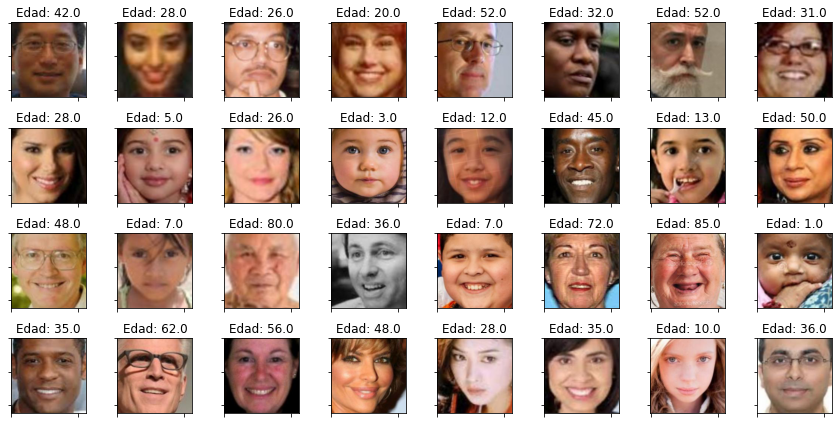

In [10]:
trn_tsfm = transforms.Compose([
    # redimensionamos a 224x224
    transforms.Resize(IMG_SIZE),
    # recortamos al centro a 224x224
    transforms.CenterCrop(IMG_SIZE),
    # espejeo horizontal con probabilidad de 0.5
    transforms.RandomHorizontalFlip(p=0.5),
    # de numpy.ndarray    (H x W x C) en rango [0, 255]
    # a torch.FloatTensor (C x H x W) en rango [0, 1]
    transforms.ToTensor(),
])

# Se establece el tipo de transformación para el conjunto de entrenamiento
trn_ds.dataset.tsfm = trn_tsfm
print(trn_ds.dataset.tsfm)

trn_dl = DataLoader(
    # conjunto
    trn_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True
)

print(len(trn_dl.dataset))

x, y = next(iter(trn_dl))
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')
titles = [f'Edad: {l.item()}' for l in y]
display_batch(x, titles, ROWS, COLS)

#### Prueba

Compose(
    Resize(size=224, interpolation=bilinear, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
    ToTensor()
)
4742
x shape=torch.Size([32, 3, 224, 224]) dtype=torch.float32
y shape=torch.Size([32, 1]) dtype=torch.float32


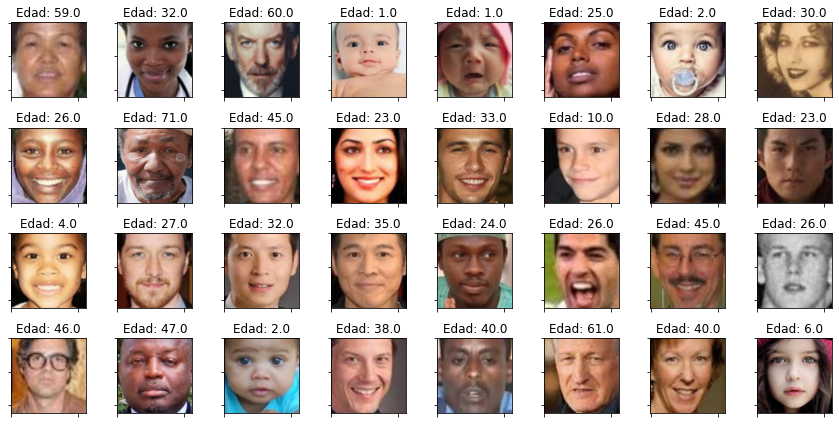

In [11]:
# transformaciones para la imagen
tst_tsfm = transforms.Compose([
    # redimensionamos a 224x224
    transforms.Resize(IMG_SIZE),
    # recortamos al centro a 224x224
    transforms.CenterCrop(IMG_SIZE),
    # convertimos a torch.Tensor y escalamos a [0,1]
    transforms.ToTensor(),
    # estandarizamos: restamos la media y dividimos sobre la varianza
    #transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

# Se establece el tipo de transformación para el conjunto de entrenamiento
tst_ds.dataset.tsfm = tst_tsfm
print(tst_ds.dataset.tsfm)

# creamos un DataLoader
tst_dl = DataLoader(
    # subconjunto
    tst_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True
)

print(len(tst_dl.dataset))

x, y = next(iter(tst_dl))
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')
titles = [f'Edad: {l.item()}' for l in y]
display_batch(x, titles, ROWS, COLS)

## 3 Modelo

<!-- ![arch](https://raw.githubusercontent.com/richardtml/riiaa-20-aa/master/media/fc.jpg) -->

### 3.1 Definición de bloque ConvNeXt

<center><img src="https://raw.githubusercontent.com/diego200052/Aprendizaje-Profundo-Tarea02-MMDR/main/img/convNextBloque.png" width="200"/></center>

In [12]:
class ConvNeXtBlock(nn.Module):

    def __init__(self, in_channels, out_channels):
        super(ConvNeXtBlock, self).__init__()
        out_channels1, out_channels2 = out_channels

        # [N, I, H, W] => [N, I, H, W]
        # Deephwise conv https://discuss.pytorch.org/t/how-to-modify-a-conv2d-to-depthwise-separable-convolution/15843/6
        self.dwconv = nn.Conv2d(in_channels=in_channels,
                      out_channels=in_channels,
                      kernel_size=7, padding=3, groups=in_channels)
        
        # En el forward se permuta, porque el layer norm requiere los canales al final.
        # [N, I, H, W] => [N, H, W, I]
        
        # Layer norm
        # [N, H, W, I] => [N, H, W, I]
        self.layernorm = nn.LayerNorm(in_channels)
        
        # En el forward se permuta, para regresar los canales donde estaban.
        # [N, H, W, I] => [N, I, H, W]
        
        # Conv, 1x1, 4C
        # [N, I, H, W] => [N, O1*4, H, W] en este caso I, O1 y O2 son iguales
        self.conv1 = nn.Conv2d(in_channels=in_channels,
                      out_channels=out_channels1*4,
                      kernel_size=1, padding=0, stride=1)
        
        # GELU
        # [N, O1*4, H, W] => [N, O1*4, H, W]
        self.gelu = nn.GELU()
            
        # Conv, 1x1, C
        # [N, O1*4, H, W] => [N, O2, H, W] en este caso I, O1 y O2 son iguales
        self.conv2 = nn.Conv2d(in_channels=out_channels1*4,
                      out_channels=out_channels2,
                      kernel_size=1, padding=0, stride=1)

    def forward(self, x):
        # [N, I, H, W] => [N, O2, H, W]. I = 3, O1 = 3, O2 = 3
        
        x1 = self.dwconv(x) # [N, I, H, W] => [N, I, H, W]
        x1 = x1.permute(0, 2, 3, 1) # [N, I, H, W] -> [N, H, W, I]
        x1 = self.layernorm(x1) # [N, I, H, W] -> [N, I, H, W]
        x1 = x1.permute(0, 3, 1, 2) # [N, H, W, I] -> [N, I, H, W]
        x1 = self.conv1(x1)# [N, I, H, W] => [N, O1*4, H, W]
        x1 = self.gelu(x1)# [N, O1*4, H, W] => [N, O1*4, H, W]
        x1 = self.conv2(x1)# [N, O1*4, H, W] => [N, O2, H, W]
        
        # [N, O2, H, W] + [N, I, H, W]
        x = x1 + x
        
        return x

### 3.1 Definición de la arquitectura


<img src="https://raw.githubusercontent.com/gibranfp/CursoAprendizajeProfundo/c40334469ccae2911fba0cc15492364e0cebc2c9/figs/resnet_arq.svg" width="250"/>

In [13]:
class MicroConvNeXt(nn.Module):

    def __init__(self):
        super(MicroConvNeXt, self).__init__()
        self.num_feats = 3 * 112 * 112
        
        # [N, 3, 224, 224] => [N, 3, 112, 112]
        self.cnn = nn.Sequential(
            # [N, 3, 224, 224] => [N, 3, 224, 224]
            ConvNeXtBlock(in_channels=3, out_channels=(3,3)),
            # [N, 3, 224, 224] => [N, 3, 112, 112]
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        # [N, 3, 112, 112] => [N, 3 x 112 x 112]
        self.flatten = nn.Flatten()

        # [N, 3 x 112 x 112] => [N, 1]
        self.cls = nn.Linear(self.num_feats, 1)

    def forward(self, x):
        # [N, 3, 224, 224] => [N, 3, 112, 112]
        x = self.cnn(x)
        # [N, 3, 112, 112] => [N, 3 x 112 x 112]
        x = self.flatten(x)
        # [N, 3 x 112 x 112] => [N, 1]
        x = self.cls(x)
        return x

    def predict(self, x):
        # [N, 3, 224, 224] => [N, 1]
        y_lgts = self.forward(x)
        # [N, 1]
        y_prob = torch.sigmoid(y_lgts)
        return y_prob

### 3.2 Inspección de la arquitectura

In [14]:
model = MicroConvNeXt()
summary_torchsummary(model, (3, IMG_SIZE, IMG_SIZE), device='cpu', verbose=0)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 3, 112, 112]         --
|    └─ConvNeXtBlock: 2-1                [-1, 3, 224, 224]         --
|    |    └─Conv2d: 3-1                  [-1, 3, 224, 224]         150
|    |    └─LayerNorm: 3-2               [-1, 224, 224, 3]         6
|    |    └─Conv2d: 3-3                  [-1, 12, 224, 224]        48
|    |    └─GELU: 3-4                    [-1, 12, 224, 224]        --
|    |    └─Conv2d: 3-5                  [-1, 3, 224, 224]         39
|    └─MaxPool2d: 2-2                    [-1, 3, 112, 112]         --
├─Flatten: 1-2                           [-1, 37632]               --
├─Linear: 1-3                            [-1, 1]                   37,633
Total params: 37,876
Trainable params: 37,876
Non-trainable params: 0
Total mult-adds (M): 11.03
Input size (MB): 0.57
Forward/backward pass size (MB): 8.04
Params size (MB): 0.14
Estimated Total Size (MB): 8.76

### 3.3 Prueba de la arquitectura

In [15]:
# inferencia con datos sinteticos
x = torch.zeros(1, 3, IMG_SIZE, IMG_SIZE)
y = model(x)
print(y.shape)

torch.Size([1, 1])


## 4 Entrenamiento

<img src="https://raw.githubusercontent.com/gibranfp/CursoAprendizajeProfundo/10c165ec21ef9d52c7b2e7648891f3a2c5d71d95/figs/comida_entrenamiento.svg" width="650"/>

### 4.1 Ciclo de entrenamiento

In [16]:
# obtenemos dispositivo en gpu, si no en cpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [17]:
# movemos el modelo 
model = model.to(device)
next(model.parameters()).device

device(type='cuda', index=0)

In [18]:
def train_epoch(dl, model, opt):
    model.train()
    # por cada lote
    for x, y_true in dl:
        
        # movemos a dispositivo
        x = x.to(device)
        y_true = y_true.to(device)
        
        # computamos logits
        y_lgts = model(x)
        
        # computamos la pérdida
        loss = F.mse_loss(y_lgts, y_true)

        # vaciamos los gradientes
        opt.zero_grad()
        
        # retropropagamos
        loss.backward()
        
        # actualizamos parámetros
        opt.step()


def eval_epoch(dl, model, num_batches=None):
    model.eval()
    # evitamos que se registren las operaciones 
    # en la gráfica de cómputo
    with torch.no_grad():

        # historial mse
        mses = []

        # validación de la época con num_batches
        # si num_batches==None, se usan todos los lotes
        for x, y_true in take(dl, num_batches):
            
            # movemos a dispositivo
            x = x.to(device)
            y_true = y_true.to(device)

            # computamos los logits
            y_lgts = model(x)
            
            # redondea los logits, edades enteras solamente
            y_pred = torch.round(y_lgts)

            # computamos la pérdida
            mse = F.mse_loss(y_pred, y_true)

            # guardamos históricos
            mses.append(mse.item())

        # promediamos métricas
        mse = np.mean(mses)

        return mse
        
        
def train(model, trn_dl, tst_dl, lr=1e-1, epochs=15,
          trn_batches=None):

    # historial mse
    mse_hist_trn, mse_hist_tst = [], []
    
    # optimizador
    opt = optim.SGD(model.parameters(), lr=lr)

    # ciclo de entrenamiento
    for epoch in range(epochs):

        # entrenamos la época
        train_epoch(trn_dl, model, opt)
        
        # evaluamos la época en entrenamiento
        trn_mse = eval_epoch(trn_dl, model, trn_batches)

        # evaluamos la época en prueba
        tst_mse = eval_epoch(tst_dl, model, trn_batches)

        # guardamos historial
        mse_hist_trn.append(trn_mse)
        mse_hist_tst.append(tst_mse)

        # imprimimos progreso
        print(f'E{epoch:02} mse (train)={trn_mse:7.2f} mse (test)={tst_mse:7.2f}')

    return mse_hist_trn, mse_hist_tst

In [19]:
mse_hist_trn, mse_hist_tst = train(model, trn_dl, tst_dl, lr=1e-4, epochs=10)

E00 mse (train)= 290.02 mse (test)= 292.66
E01 mse (train)= 231.33 mse (test)= 237.07
E02 mse (train)= 220.23 mse (test)= 224.89
E03 mse (train)= 209.85 mse (test)= 214.19
E04 mse (train)= 201.31 mse (test)= 205.29
E05 mse (train)= 214.64 mse (test)= 218.35
E06 mse (train)= 210.81 mse (test)= 217.70
E07 mse (train)= 204.34 mse (test)= 209.34
E08 mse (train)= 240.49 mse (test)= 245.42
E09 mse (train)= 179.62 mse (test)= 185.33


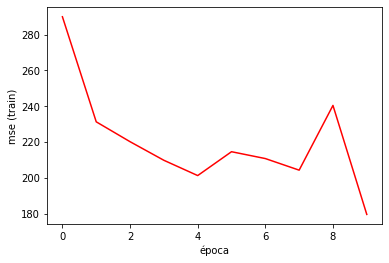

In [20]:
plt.plot(mse_hist_trn, color='red')
plt.xlabel('época')
plt.ylabel('mse (train)')
plt.show()

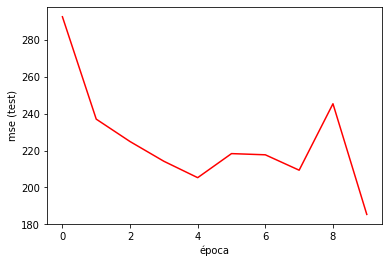

In [21]:
plt.plot(mse_hist_tst, color='red')
plt.xlabel('época')
plt.ylabel('mse (test)')
plt.show()

## 5. Probando

In [22]:
model = model.to('cpu')

### 5.1 Evaluando en entrenamiento

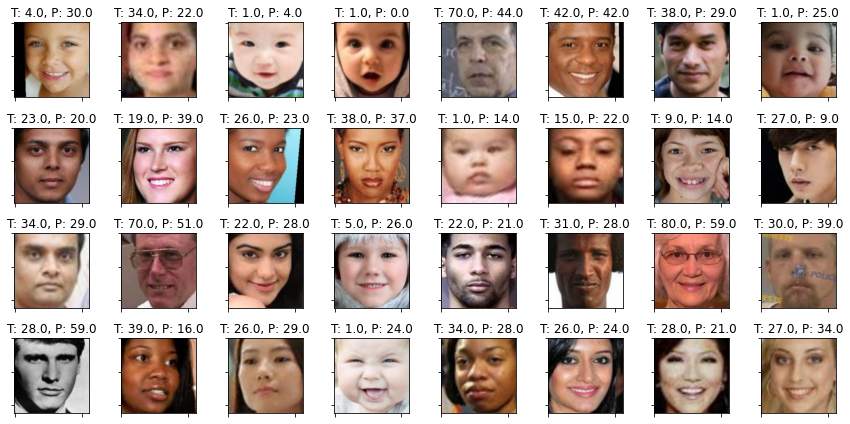

In [23]:
model.eval()
with torch.no_grad():
    x, y_true = next(iter(trn_dl))
    y_lgts = model(x)
    y_pred = torch.round(y_lgts)
    titles = [f'T: {t.item()}, P: {p.item()}' for t,p in zip(y_true,y_pred)]
    display_batch(x, titles, ROWS, COLS)

### 5.2 Evaluando en prueba

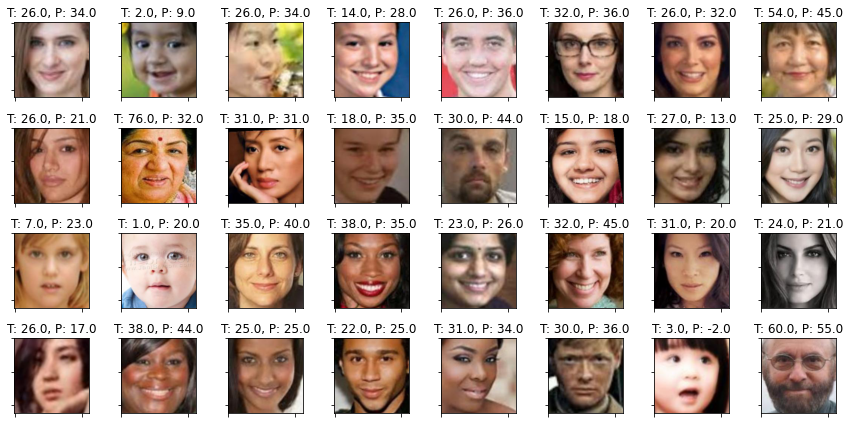

In [24]:
model.eval()
with torch.no_grad():
    x, y_true = next(iter(tst_dl))
    y_lgts = model(x)
    y_pred = torch.round(y_lgts)
    titles = [f'T: {t.item()}, P: {p.item()}' for t,p in zip(y_true,y_pred)]
    display_batch(x, titles, ROWS, COLS)

## 6. Transferencia de conocimiento entrenando la última capa

### 6.1 Creación del conjunto de datos entrenamiento y prueba con normalización de IMAGENET

In [25]:
from copy import copy

dsAll = UTKFaceDS(data_dir, None)

train_size = int(0.8 * len(dsAll))
test_size = len(dsAll) - train_size
trn_ds_wNorm, tst_ds_wNorm = random_split(dsAll, [train_size, test_size], generator=torch.Generator().manual_seed(0))

# trn_ds y tst_ds son una clase de tipo Subset que comparten el mismo dataset (ds),
# pero en este caso cada uno requiere de una transformación distinta, entonces
# se realiza una copia del dataset para posteriormente, al alterar la transformación
# de prueba o entrenamiento, no se afecten en ambas, sino que sean independientes.
print( "trn dataset memdir:", hex(id(trn_ds_wNorm.dataset)) )
print( "tst dataset memdir:", hex(id(tst_ds_wNorm.dataset)), end="\n\n")
trn_ds.dataset = copy(trn_ds.dataset)
print( "(new) trn dataset memdir:", hex(id(trn_ds_wNorm.dataset)) )
print( "tst dataset memdir:", hex(id(tst_ds_wNorm.dataset)), end="\n\n" )

print("Len(ds) = ", len(ds))
print("Len(train_ds) = ", len(trn_ds_wNorm))
print("Len(test_ds) = ", len(tst_ds_wNorm))

trn dataset memdir: 0x7f8f9acf0150
tst dataset memdir: 0x7f8f9acf0150

(new) trn dataset memdir: 0x7f8f9acf0150
tst dataset memdir: 0x7f8f9acf0150

Len(ds) =  23708
Len(train_ds) =  18966
Len(test_ds) =  4742


Compose(
    Resize(size=224, interpolation=bilinear, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
    RandomHorizontalFlip(p=0.5)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
18966
x shape=torch.Size([32, 3, 224, 224]) dtype=torch.float32
y shape=torch.Size([32, 1]) dtype=torch.float32


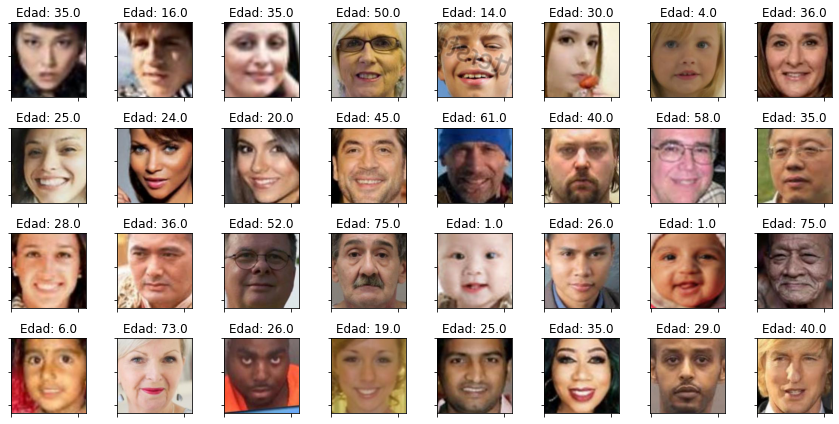

In [26]:
trn_tsfm_wNorm = transforms.Compose([
    # redimensionamos a 224x224
    transforms.Resize(IMG_SIZE),
    # recortamos al centro a 224x224
    transforms.CenterCrop(IMG_SIZE),
    # espejeo horizontal con probabilidad de 0.5
    transforms.RandomHorizontalFlip(p=0.5),
    # de numpy.ndarray    (H x W x C) en rango [0, 255]
    # a torch.FloatTensor (C x H x W) en rango [0, 1]
    transforms.ToTensor(),
    # estandarizamos con media y varianza
    T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

# Se establece el tipo de transformación para el conjunto de entrenamiento
trn_ds_wNorm.dataset.tsfm = trn_tsfm_wNorm
print(trn_ds_wNorm.dataset.tsfm)

trn_dl_wNorm = DataLoader(
    # conjunto
    trn_ds_wNorm,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True
)

print(len(trn_dl_wNorm.dataset))

x, y = next(iter(trn_dl_wNorm))
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')
titles = [f'Edad: {l.item()}' for l in y]
display_batch_IMAGENET(x, titles, ROWS, COLS)

Compose(
    Resize(size=224, interpolation=bilinear, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
4742
x shape=torch.Size([32, 3, 224, 224]) dtype=torch.float32
y shape=torch.Size([32, 1]) dtype=torch.float32


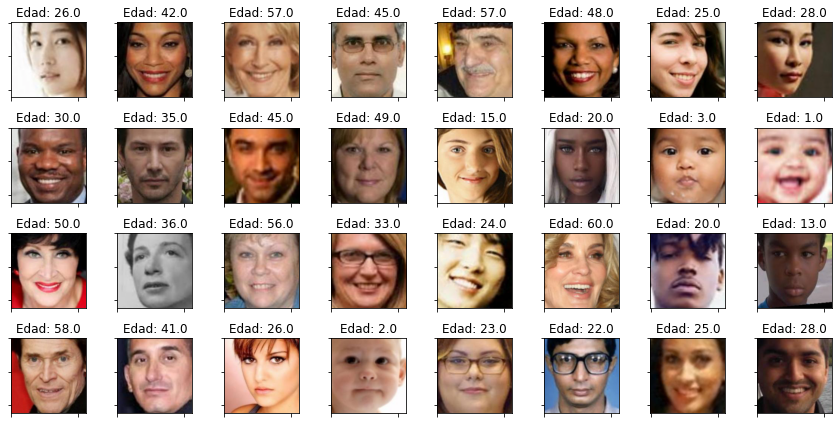

In [27]:
# transformaciones para la imagen
tst_tsfm_wNorm = transforms.Compose([
    # redimensionamos a 224x224
    transforms.Resize(IMG_SIZE),
    # recortamos al centro a 224x224
    transforms.CenterCrop(IMG_SIZE),
    # convertimos a torch.Tensor y escalamos a [0,1]
    transforms.ToTensor(),
    # estandarizamos: restamos la media y dividimos sobre la varianza
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

# Se establece el tipo de transformación para el conjunto de entrenamiento
tst_ds_wNorm.dataset.tsfm = tst_tsfm_wNorm
print(tst_ds_wNorm.dataset.tsfm)

# creamos un DataLoader
tst_dl_wNorm = DataLoader(
    # subconjunto
    tst_ds_wNorm,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True
)

print(len(tst_dl_wNorm.dataset))

x, y = next(iter(tst_dl_wNorm))
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')
titles = [f'Edad: {l.item()}' for l in y]
display_batch_IMAGENET(x, titles, ROWS, COLS)

## 6.2 Modelo

Torchvision provee una familia de modelos preentrenados en ImageNet. Se usará Shufflenet V2, una arquitectura eficiente para clasificación de imágenes.

In [28]:
# instancia de modelo y carga de pesos
model_shufflenet = tvm.shufflenet_v2_x0_5(pretrained=True)
model_shufflenet

Downloading: "https://download.pytorch.org/models/shufflenetv2_x0.5-f707e7126e.pth" to /root/.cache/torch/hub/checkpoints/shufflenetv2_x0.5-f707e7126e.pth


  0%|          | 0.00/5.28M [00:00<?, ?B/s]

ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): InvertedResidual(
      (branch1): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(24, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
      (branch2): Sequential(
        (0): Conv2d(24, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_

## 6.3 Transferencia de conocimiento

In [29]:
# congelamos los parámetros
for param in model_shufflenet.parameters():
    # no participa en la retropropagación
    param.requires_grad = False
# congelamos las estadísticas
model_shufflenet.eval()

# remplazo de última capa
model_shufflenet.fc = nn.Linear(1024, 1)

# inspección
summary_torchinfo(model_shufflenet, (1, 3, IMG_SIZE, IMG_SIZE), 
        device='cpu', verbose=0)

Layer (type:depth-idx)                   Output Shape              Param #
ShuffleNetV2                             [1, 1]                    --
├─Sequential: 1-1                        [1, 24, 112, 112]         --
│    └─Conv2d: 2-1                       [1, 24, 112, 112]         (648)
│    └─BatchNorm2d: 2-2                  [1, 24, 112, 112]         (48)
│    └─ReLU: 2-3                         [1, 24, 112, 112]         --
├─MaxPool2d: 1-2                         [1, 24, 56, 56]           --
├─Sequential: 1-3                        [1, 48, 28, 28]           --
│    └─InvertedResidual: 2-4             [1, 48, 28, 28]           --
│    │    └─Sequential: 3-1              [1, 24, 28, 28]           (888)
│    │    └─Sequential: 3-2              [1, 24, 28, 28]           (1,512)
│    └─InvertedResidual: 2-5             [1, 48, 28, 28]           --
│    │    └─Sequential: 3-3              [1, 24, 28, 28]           (1,512)
│    └─InvertedResidual: 2-6             [1, 48, 28, 28]           

## 6.4 Entrenamiento

In [30]:
# movemos el modelo 
model_shufflenet = model_shufflenet.to(device)
next(model_shufflenet.parameters()).device

device(type='cuda', index=0)

In [31]:
mse_hist_trn_shufflenet, mse_hist_tst_shufflenet = train(model_shufflenet, trn_dl_wNorm, tst_dl_wNorm, lr=1e-1, epochs=10)

E00 mse (train)= 219.58 mse (test)= 213.26
E01 mse (train)= 189.67 mse (test)= 186.36
E02 mse (train)= 179.46 mse (test)= 176.40
E03 mse (train)= 175.49 mse (test)= 173.76
E04 mse (train)= 170.39 mse (test)= 168.82
E05 mse (train)= 163.64 mse (test)= 162.99
E06 mse (train)= 162.53 mse (test)= 162.26
E07 mse (train)= 173.22 mse (test)= 174.61
E08 mse (train)= 163.08 mse (test)= 164.56
E09 mse (train)= 156.03 mse (test)= 157.60


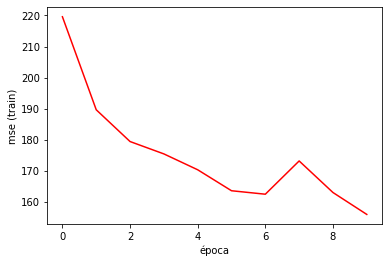

In [32]:
plt.plot(mse_hist_trn_shufflenet, color='red')
plt.xlabel('época')
plt.ylabel('mse (train)')
plt.show()

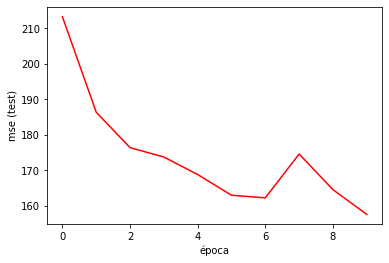

In [33]:
plt.plot(mse_hist_tst_shufflenet, color='red')
plt.xlabel('época')
plt.ylabel('mse (test)')
plt.show()

## 6.5 Probando

In [34]:
model_shufflenet = model_shufflenet.to('cpu')

### 6.5.1 Evaluando en entrenamiento

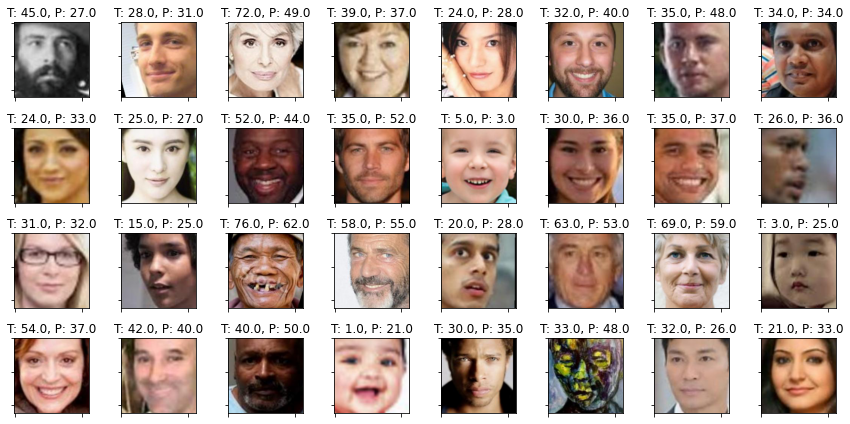

In [37]:
model_shufflenet.eval()
with torch.no_grad():
    x, y_true = next(iter(trn_dl_wNorm))
    y_lgts = model_shufflenet(x)
    y_pred = torch.round(y_lgts)
    titles = [f'T: {t.item()}, P: {p.item()}' for t,p in zip(y_true,y_pred)]
    display_batch_IMAGENET(x, titles, ROWS, COLS)

### 6.5.1 Evaluando en prueba

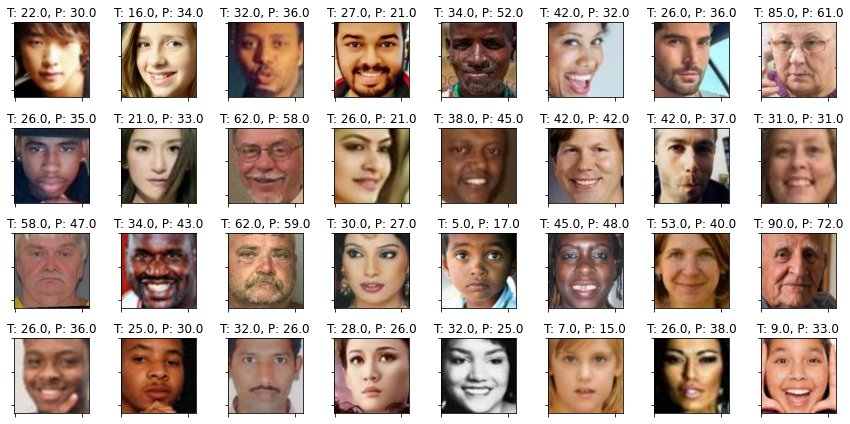

In [38]:
model_shufflenet.eval()
with torch.no_grad():
    x, y_true = next(iter(tst_dl_wNorm))
    y_lgts = model_shufflenet(x)
    y_pred = torch.round(y_lgts)
    titles = [f'T: {t.item()}, P: {p.item()}' for t,p in zip(y_true,y_pred)]
    display_batch_IMAGENET(x, titles, ROWS, COLS)

# 7. Transferencia de conocimiento entrenando toda la red

## 7.1 Modelo

In [44]:
# instancia de modelo y carga de pesos
model_shufflenet_all = tvm.shufflenet_v2_x0_5(pretrained=True)
model_shufflenet_all

ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): InvertedResidual(
      (branch1): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(24, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
      (branch2): Sequential(
        (0): Conv2d(24, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_

In [45]:
# congelamos los parámetros
#for param in model_shufflenet.parameters():
    # no participa en la retropropagación
#    param.requires_grad = False
# congelamos las estadísticas
#model_shufflenet.eval()

# remplazo de última capa
model_shufflenet_all.fc = nn.Linear(1024, 1)

# inspección
summary_torchinfo(model_shufflenet_all, (1, 3, IMG_SIZE, IMG_SIZE), 
        device='cpu', verbose=0)

Layer (type:depth-idx)                   Output Shape              Param #
ShuffleNetV2                             [1, 1]                    --
├─Sequential: 1-1                        [1, 24, 112, 112]         --
│    └─Conv2d: 2-1                       [1, 24, 112, 112]         648
│    └─BatchNorm2d: 2-2                  [1, 24, 112, 112]         48
│    └─ReLU: 2-3                         [1, 24, 112, 112]         --
├─MaxPool2d: 1-2                         [1, 24, 56, 56]           --
├─Sequential: 1-3                        [1, 48, 28, 28]           --
│    └─InvertedResidual: 2-4             [1, 48, 28, 28]           --
│    │    └─Sequential: 3-1              [1, 24, 28, 28]           888
│    │    └─Sequential: 3-2              [1, 24, 28, 28]           1,512
│    └─InvertedResidual: 2-5             [1, 48, 28, 28]           --
│    │    └─Sequential: 3-3              [1, 24, 28, 28]           1,512
│    └─InvertedResidual: 2-6             [1, 48, 28, 28]           --
│    │ 

## 7.2 Entrenamiento

In [46]:
# movemos el modelo 
model_shufflenet_all = model_shufflenet_all.to(device)
next(model_shufflenet_all.parameters()).device

device(type='cuda', index=0)

In [48]:
mse_hist_trn_shufflenet_all, mse_hist_tst_shufflenet_all = train(model_shufflenet_all, trn_dl_wNorm, tst_dl_wNorm, lr=5e-5, epochs=10)

E00 mse (train)= 614.06 mse (test)= 614.70
E01 mse (train)= 192.04 mse (test)= 194.23
E02 mse (train)=  94.41 mse (test)= 101.93
E03 mse (train)=  80.19 mse (test)=  90.89
E04 mse (train)=  74.72 mse (test)=  85.46
E05 mse (train)=  69.42 mse (test)=  82.92
E06 mse (train)=  59.08 mse (test)=  76.00
E07 mse (train)=  56.44 mse (test)=  74.98
E08 mse (train)=  52.87 mse (test)=  75.75
E09 mse (train)=  46.86 mse (test)=  71.22


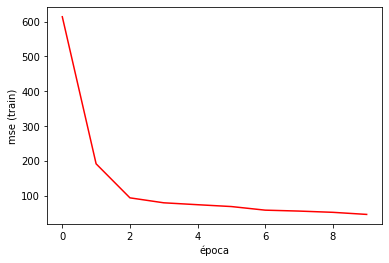

In [49]:
plt.plot(mse_hist_trn_shufflenet_all, color='red')
plt.xlabel('época')
plt.ylabel('mse (train)')
plt.show()

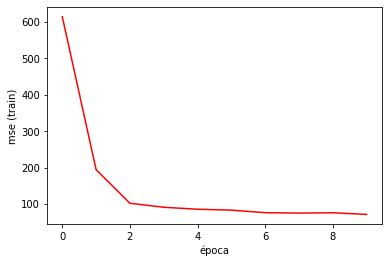

In [50]:
plt.plot(mse_hist_tst_shufflenet_all, color='red')
plt.xlabel('época')
plt.ylabel('mse (train)')
plt.show()

## 7.3 Probando

In [51]:
model_shufflenet_all = model_shufflenet_all.to('cpu')

### 7.3.1 Evaluando en entrenamiento

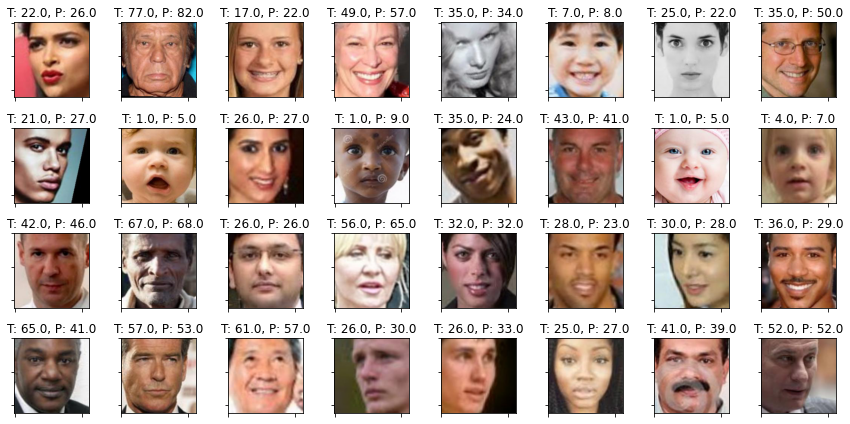

In [52]:
model_shufflenet_all.eval()
with torch.no_grad():
    x, y_true = next(iter(trn_dl_wNorm))
    y_lgts = model_shufflenet_all(x)
    y_pred = torch.round(y_lgts)
    titles = [f'T: {t.item()}, P: {p.item()}' for t,p in zip(y_true,y_pred)]
    display_batch_IMAGENET(x, titles, ROWS, COLS)

### 7.3.2 Evaluando en prueba

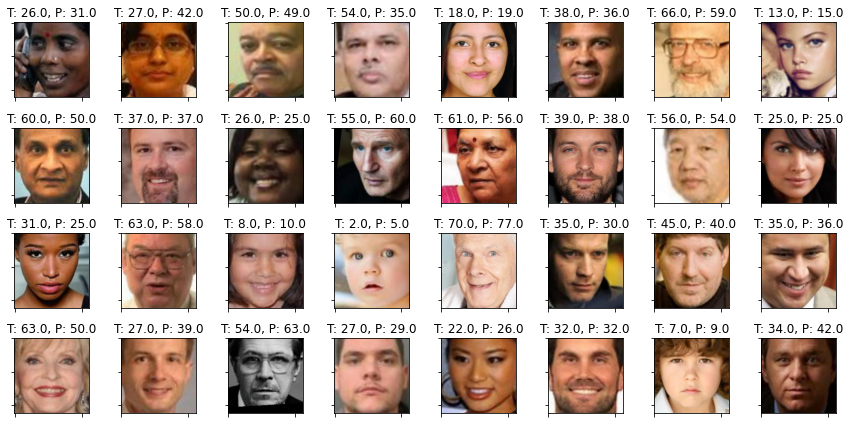

In [53]:
model_shufflenet_all.eval()
with torch.no_grad():
    x, y_true = next(iter(tst_dl_wNorm))
    y_lgts = model_shufflenet_all(x)
    y_pred = torch.round(y_lgts)
    titles = [f'T: {t.item()}, P: {p.item()}' for t,p in zip(y_true,y_pred)]
    display_batch_IMAGENET(x, titles, ROWS, COLS)

# Conclusiones y discusión

En el caso de la red neuronal convolucional (CNN) que usa bloques ConvNeXT en el conjunto de prueba se obtuvo un MSE de 185.33. Para el experimento de aprendizaje por transferencia de conocimiento, remplazando la última capa por una lineal y entrenando sólo esa capa se obtiene para el conjunto de prueba un MSE de 157.60. Finalmente, para el experimento de aprendizaje por transferencia de conocimiento, pero entrenando toda la red, para el conjunto de prueba se obtiene un MSE de 71.22. Todos fueron entrenados con 10 épocas. La tasa de aprendizaje se ajustó lo mejor posible.
  
En los primeros 2 experimentos tanto el MSE en el cojunto de entrenamiento como en el de prueba eran muy similares. En cambio en el último experimento que entrenó toda la red, para el conjunto de prueba se ajustó mejor el modelo que para el de entrenamiento, sin embargo, no hay sobre-ajuste.
  
En conclusión, el aprendizaje por transferencia de conocimiento entrenando toda la red fue el que obtuvo mejor predicciones.
  
Esto se debe a varias razones. Primero la red CNN con bloque ConvNeXT, únicamente posee 1 solo bloque apilado, por lo que quizás se podría mejorar el rendimiento si se apilaran más bloques. Sin embargo, el número de parámetros entrenables es menor y se entrenó rápidamente.
  
Por otro lado, en la red en la que solo se entrena la última capa, mejora con respecto a la CNN, pero no es mucho. Probablemente porque para predecir la edad se requiera extraer otro tipo de características más específicas. Por ejemplo, para identificar las arrugas. Es por eso que en el último experimento se obtiene un mejor rendimiento. Ya que se actualizan los pesos de la red convolucional para ajustarse a los datos de las caras. Como ya se inició con parámetros buenos de una red previamente entrenada, fue que en pocas épocas se obtuvo un rendimiento bueno a pesar de la cantidad grande del número de parámetros. Además de utilizar una tasa de aprendizaje baja.